<a href="https://colab.research.google.com/github/PRaliphada/ExpectedLoss/blob/main/Pfarelo_and_Phuti_NLP_LAB2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Validation Accuracy: 35.47%
Test Accuracy: 33.33%
Train data size: 1311
Validation data size: 437
Test data size: 438

Precision Scores:
Book  Precision
 HP1   0.518519
 HP2   0.500000
 HP3   0.434783
 HP4   0.828947
 HP5   0.141509
 HP6   0.126761
 HP7   0.081081

Confusion Matrix:
     HP1  HP2  HP3  HP4  HP5  HP6  HP7
HP1   14   10    9    4   24   25   33
HP2    6   19   10    7   43   26   25
HP3    6    6   20    0   22    8    9
HP4    1    3    4   63    1    3    1
HP5    0    0    3    2   15    0    0
HP6    0    0    0    0    0    9    0
HP7    0    0    0    0    1    0    6


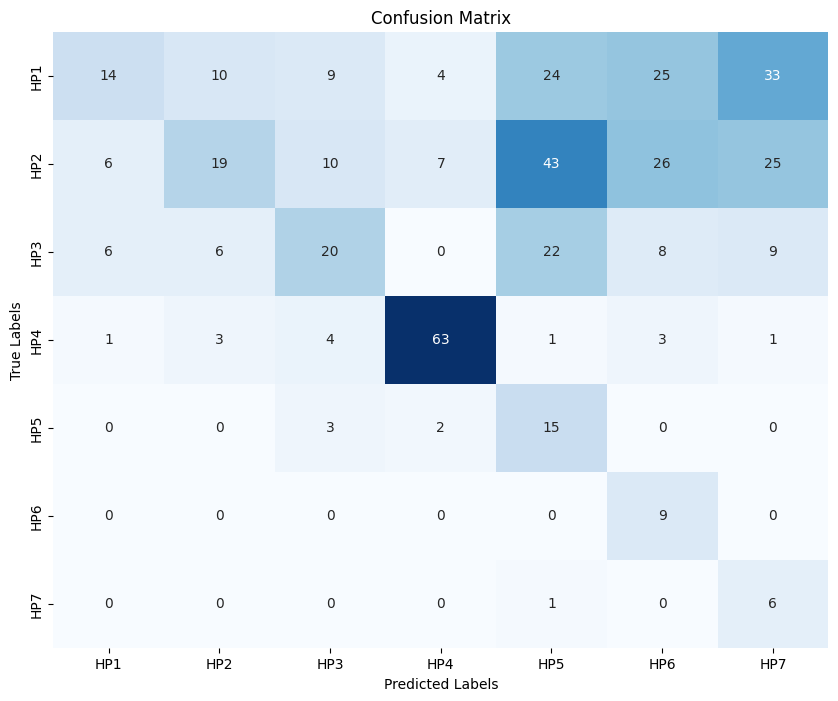

In [17]:
# Pfarelo Raliphada 1593057
# Phuti Bambo 1263825
# LAB 2

import os
import re
from collections import defaultdict
from nltk import ngrams
from nltk.tokenize import word_tokenize
import random
import nltk
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
nltk.download('punkt')

# Load Harry Potter books.
def load_corpus(directory):
    corpus = {}
    for idx, filename in enumerate(sorted(os.listdir(directory))):
        if filename.endswith(".txt"):
            book_label = f"HP{idx}"  # Labeling HP1 to HP7
            with open(os.path.join(directory, filename), 'r', encoding='utf-8') as file:
                corpus[book_label] = file.read().lower()
    return corpus

# Preprocess the data by removing punctuation and tokenizing the text.
def preprocess(text):
    text = re.sub(r'[^\w\s]', '', text)
    tokens = word_tokenize(text)
    return tokens

# Generate N-grams from tokens.
def generate_ngrams(tokens, n):
    return list(ngrams(tokens, n))

# Split the book text into chunks.
def split_into_chunks(text, chunk_size=500):
    tokens = preprocess(text)
    chunks = [' '.join(tokens[i:i + chunk_size]) for i in range(0, len(tokens), chunk_size)]
    return chunks

# Prepare the data with labels.
def prepare_data(corpus, ngram_size=4, chunk_size=500):
    labeled_data = []
    for book_label, text in corpus.items():
        chunks = split_into_chunks(text, chunk_size)
        for chunk in chunks:
            ngrams_list = generate_ngrams(preprocess(chunk), ngram_size)
            labeled_data.append((book_label, ngrams_list))
    return labeled_data

# Split data into train, validation, and test datasets.
def split_data(data, train_ratio=0.6, val_ratio=0.2):
    random.shuffle(data)

    train_size = int(len(data) * train_ratio)
    val_size = int(len(data) * val_ratio)

    train_data = data[:train_size]
    val_data = data[train_size:train_size + val_size]
    test_data = data[train_size + val_size:]

    return train_data, val_data, test_data

# Implementing Naive Bayes Classifier with Laplace smoothing.
class NaiveBayesClassifier:
    def __init__(self):
        self.class_counts = defaultdict(int)
        self.feature_counts = defaultdict(lambda: defaultdict(int))
        self.vocab = set()

    def train(self, data):
        total_documents = len(data)
        for label, ngrams in data:
            self.class_counts[label] += len(ngrams)
            for ngram in ngrams:
                self.feature_counts[ngram][label] += 1
                self.vocab.update([ngram])

    def predict(self, ngrams):
        label_scores = defaultdict(float)

        for label in self.class_counts:
            log_prob = 0
            for ngram in ngrams:
                ngram_freq = self.feature_counts[ngram][label] + 1
                log_prob += ngram_freq / (self.class_counts[label] + len(self.vocab))

            label_scores[label] = log_prob

        return max(label_scores, key=label_scores.get)

    def evaluate(self, data):
        correct = 0
        total = 0
        for label, ngrams in data:
            prediction = self.predict(ngrams)
            if prediction == label:
                correct += 1
            total += 1

        return correct / total if total > 0 else 0

# Function to calculate precision and generate confusion matrix
def precision_and_confusion_matrix(classifier, data):
    all_labels = sorted(set(label for label, _ in data))
    label_predictions = defaultdict(list)

    for label, ngrams in data:
        prediction = classifier.predict(ngrams)
        label_predictions[label].append(prediction)

    precision_scores = {}
    confusion_matrix = defaultdict(lambda: defaultdict(int))

    for label in all_labels:
        predictions = label_predictions[label]
        tp = predictions.count(label)
        fp = len(predictions) - tp
        precision_scores[label] = tp / (tp + fp) if (tp + fp) > 0 else 0

        for predicted_label in all_labels:
            confusion_matrix[label][predicted_label] = predictions.count(predicted_label)

    return precision_scores, confusion_matrix

def visualize_results(validation_accuracy, test_accuracy, precision_scores, confusion_matrix, train_size, val_size, test_size):

    precision_df = pd.DataFrame(list(precision_scores.items()), columns=['Book', 'Precision'])

    # Print precision scores
    print("\nPrecision Scores:")
    print(precision_df.to_string(index=False))


    conf_matrix_df = pd.DataFrame(confusion_matrix).fillna(0).astype(int)

    all_labels = sorted(conf_matrix_df.columns)
    conf_matrix_df = conf_matrix_df.reindex(index=all_labels, columns=all_labels, fill_value=0)

    # Print confusion matrix
    print("\nConfusion Matrix:")
    print(conf_matrix_df)

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()


def main():
    corpus_directory = '/content/'  # Directory containing all the books
    corpus = load_corpus(corpus_directory)

    # Prepare labeled data with 4-grams
    ngram_size = 4
    chunk_size = 500
    labeled_data = prepare_data(corpus, ngram_size, chunk_size)

    # Split the data into train, validation, and test datasets
    train_data, val_data, test_data = split_data(labeled_data)

    # Training the model
    nb_classifier = NaiveBayesClassifier()
    nb_classifier.train(train_data)

    # Evaluation on validation dataset
    validation_accuracy = nb_classifier.evaluate(val_data)
    print(f'Validation Accuracy: {validation_accuracy * 100:.2f}%')

    # Evaluation on test dataset
    test_accuracy = nb_classifier.evaluate(test_data)
    print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

    # Calculate precision and generate confusion matrix
    precision_scores, confusion_matrix = precision_and_confusion_matrix(nb_classifier, test_data)

    # Printing the sizes of the datasets that are used for Training, Validation, and Testing.
    print(f'Train data size: {len(train_data)}')
    print(f'Validation data size: {len(val_data)}')
    print(f'Test data size: {len(test_data)}')

    # Visualize the results
    visualize_results(validation_accuracy, test_accuracy, precision_scores, confusion_matrix, len(train_data), len(val_data), len(test_data))

if __name__ == "__main__":
    main()


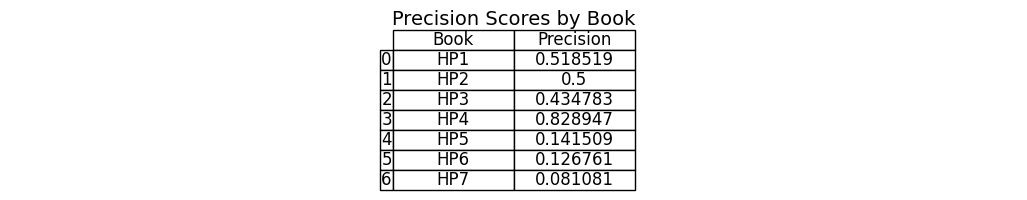

In [27]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import table

# Data
data = {
    'Book': ['HP1', 'HP2', 'HP3', 'HP4', 'HP5', 'HP6', 'HP7'],
    'Precision': [0.518519, 0.500000, 0.434783, 0.828947, 0.141509, 0.126761, 0.081081]
}

# Create DataFrame
df = pd.DataFrame(data)

# Plot table
plt.figure(figsize=(13, 2))
ax = plt.gca()
ax.axis('off')

# Create a table plot using pandas
tbl = table(ax, df, loc='center', cellLoc='center', colWidths=[0.1]*len(df.columns))

# Add row and column labels
tbl.auto_set_font_size(False)
tbl.set_fontsize(12)
tbl.scale(1.2, 1.2)  # Scale up the table

# Add title
plt.title('Precision Scores by Book', fontsize=14)

plt.show()
